In [1]:
#Visualise classification report

#Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
from tabulate import tabulate
import io
from PIL import Image

In [10]:
#Load data from csv
def load_csv_data(filename="model_results.csv"):
    """
    Load data from a CSV file in the same GitHub folder.
    
    Parameters:
    filename (str): Name of the CSV file to read, defaults to 'model_results.csv'
    
    Returns:
    pandas.DataFrame: The data from the CSV file
    """
    try:
        # Read the CSV file into a pandas DataFrame
        data = pd.read_csv(filename)
        return data
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found in the current directory.")
        return None
    except Exception as e:
        print(f"Error loading CSV data: {e}")
        return None
    


In [15]:
model_results = load_csv_data("model_results.csv")

In [16]:
print(model_results.columns)

Index(['precision', 'recall', 'f1-score', 'accuracy', 'training_time'], dtype='object')


In [21]:
def create_model_results_table(model_results):
    """
    Create a visualization table of model evaluation metrics.
    
    Parameters:
    -----------
    model_results : pandas DataFrame
        DataFrame containing precision, recall, f1-score, accuracy, and training_time
    
    Returns:
    --------
    PIL.Image.Image
        PNG image of the visualization table
    """
    # Create a copy to avoid modifying the original dataframe
    df = model_results.copy()

    # Add model index for identification
    df['training'] = [f"Training Run {i+1}" for i in range(len(df))]
    
    # Calculate average training time - safely handle different data structures
    #if len(df) == 1:
        # If there's only one row
     #   avg_training_time = df['training_time'].iloc[0]
    #else:
        # If there are multiple rows
    #    avg_training_time = pd.Series(df['training_time']).mean()

    # Select columns for visualization
    metrics_df = df[['training', 'precision', 'recall', 'f1-score', 'accuracy']]
    
    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Remove axes
    ax.axis('tight')
    ax.axis('off')
    
    # Create the table
    metrics_data = metrics_df.values.tolist()  # Convert to list for better compatibility
    column_headers = ['Training Run', 'Precision', 'Recall', 'F1-Score', 'Accuracy']
    
    # Format numeric values
    for i in range(len(metrics_data)):
        for j in range(1, 5):  # Skip the model name column
            metrics_data[i][j] = f"{float(metrics_data[i][j]):.2f}"
    
    table = ax.table(
        cellText=metrics_data,
        colLabels=column_headers,
        loc='center',
        cellLoc='center',
        colColours=['#e6e6e6'] * 5
    )
    
    # Add a row for training time at the bottom
    #bottom_row = table.add_cell(len(metrics_data), 0, 
    #                          width=1, height=0.2, 
    #                          text='Average Training Time',
    #                          loc='center')
    
   # # Add training time value
   # time_cell = table.add_cell(len(metrics_data), 1, 
   #                           width=4, height=0.2, 
   #                           text=f"{avg_training_time:.2f} seconds",
   #                           loc='center')
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    
    # Apply simple alternating row coloring for readability
    for i in range(len(metrics_data)):
        row_color = '#f2f2f2' if i % 2 == 0 else 'white'
        for j in range(len(metrics_data[i])):  # Use actual length of row
            try:
                cell = table[(i+1, j)]  # +1 because of the header row
                cell.set_facecolor(row_color)
            except KeyError:
                # Skip if cell doesn't exist
                continue
    
    # Style the bottom row
    #bottom_row.set_facecolor('#e6e6e6')
    #time_cell.set_facecolor('#e6e6e6')
    
    # Add a title
    plt.title('Model Evaluation Metrics', fontsize=16, pad=20)
    
    # Adjust layout
    plt.tight_layout()
    
    # Convert plot to image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    
    return img

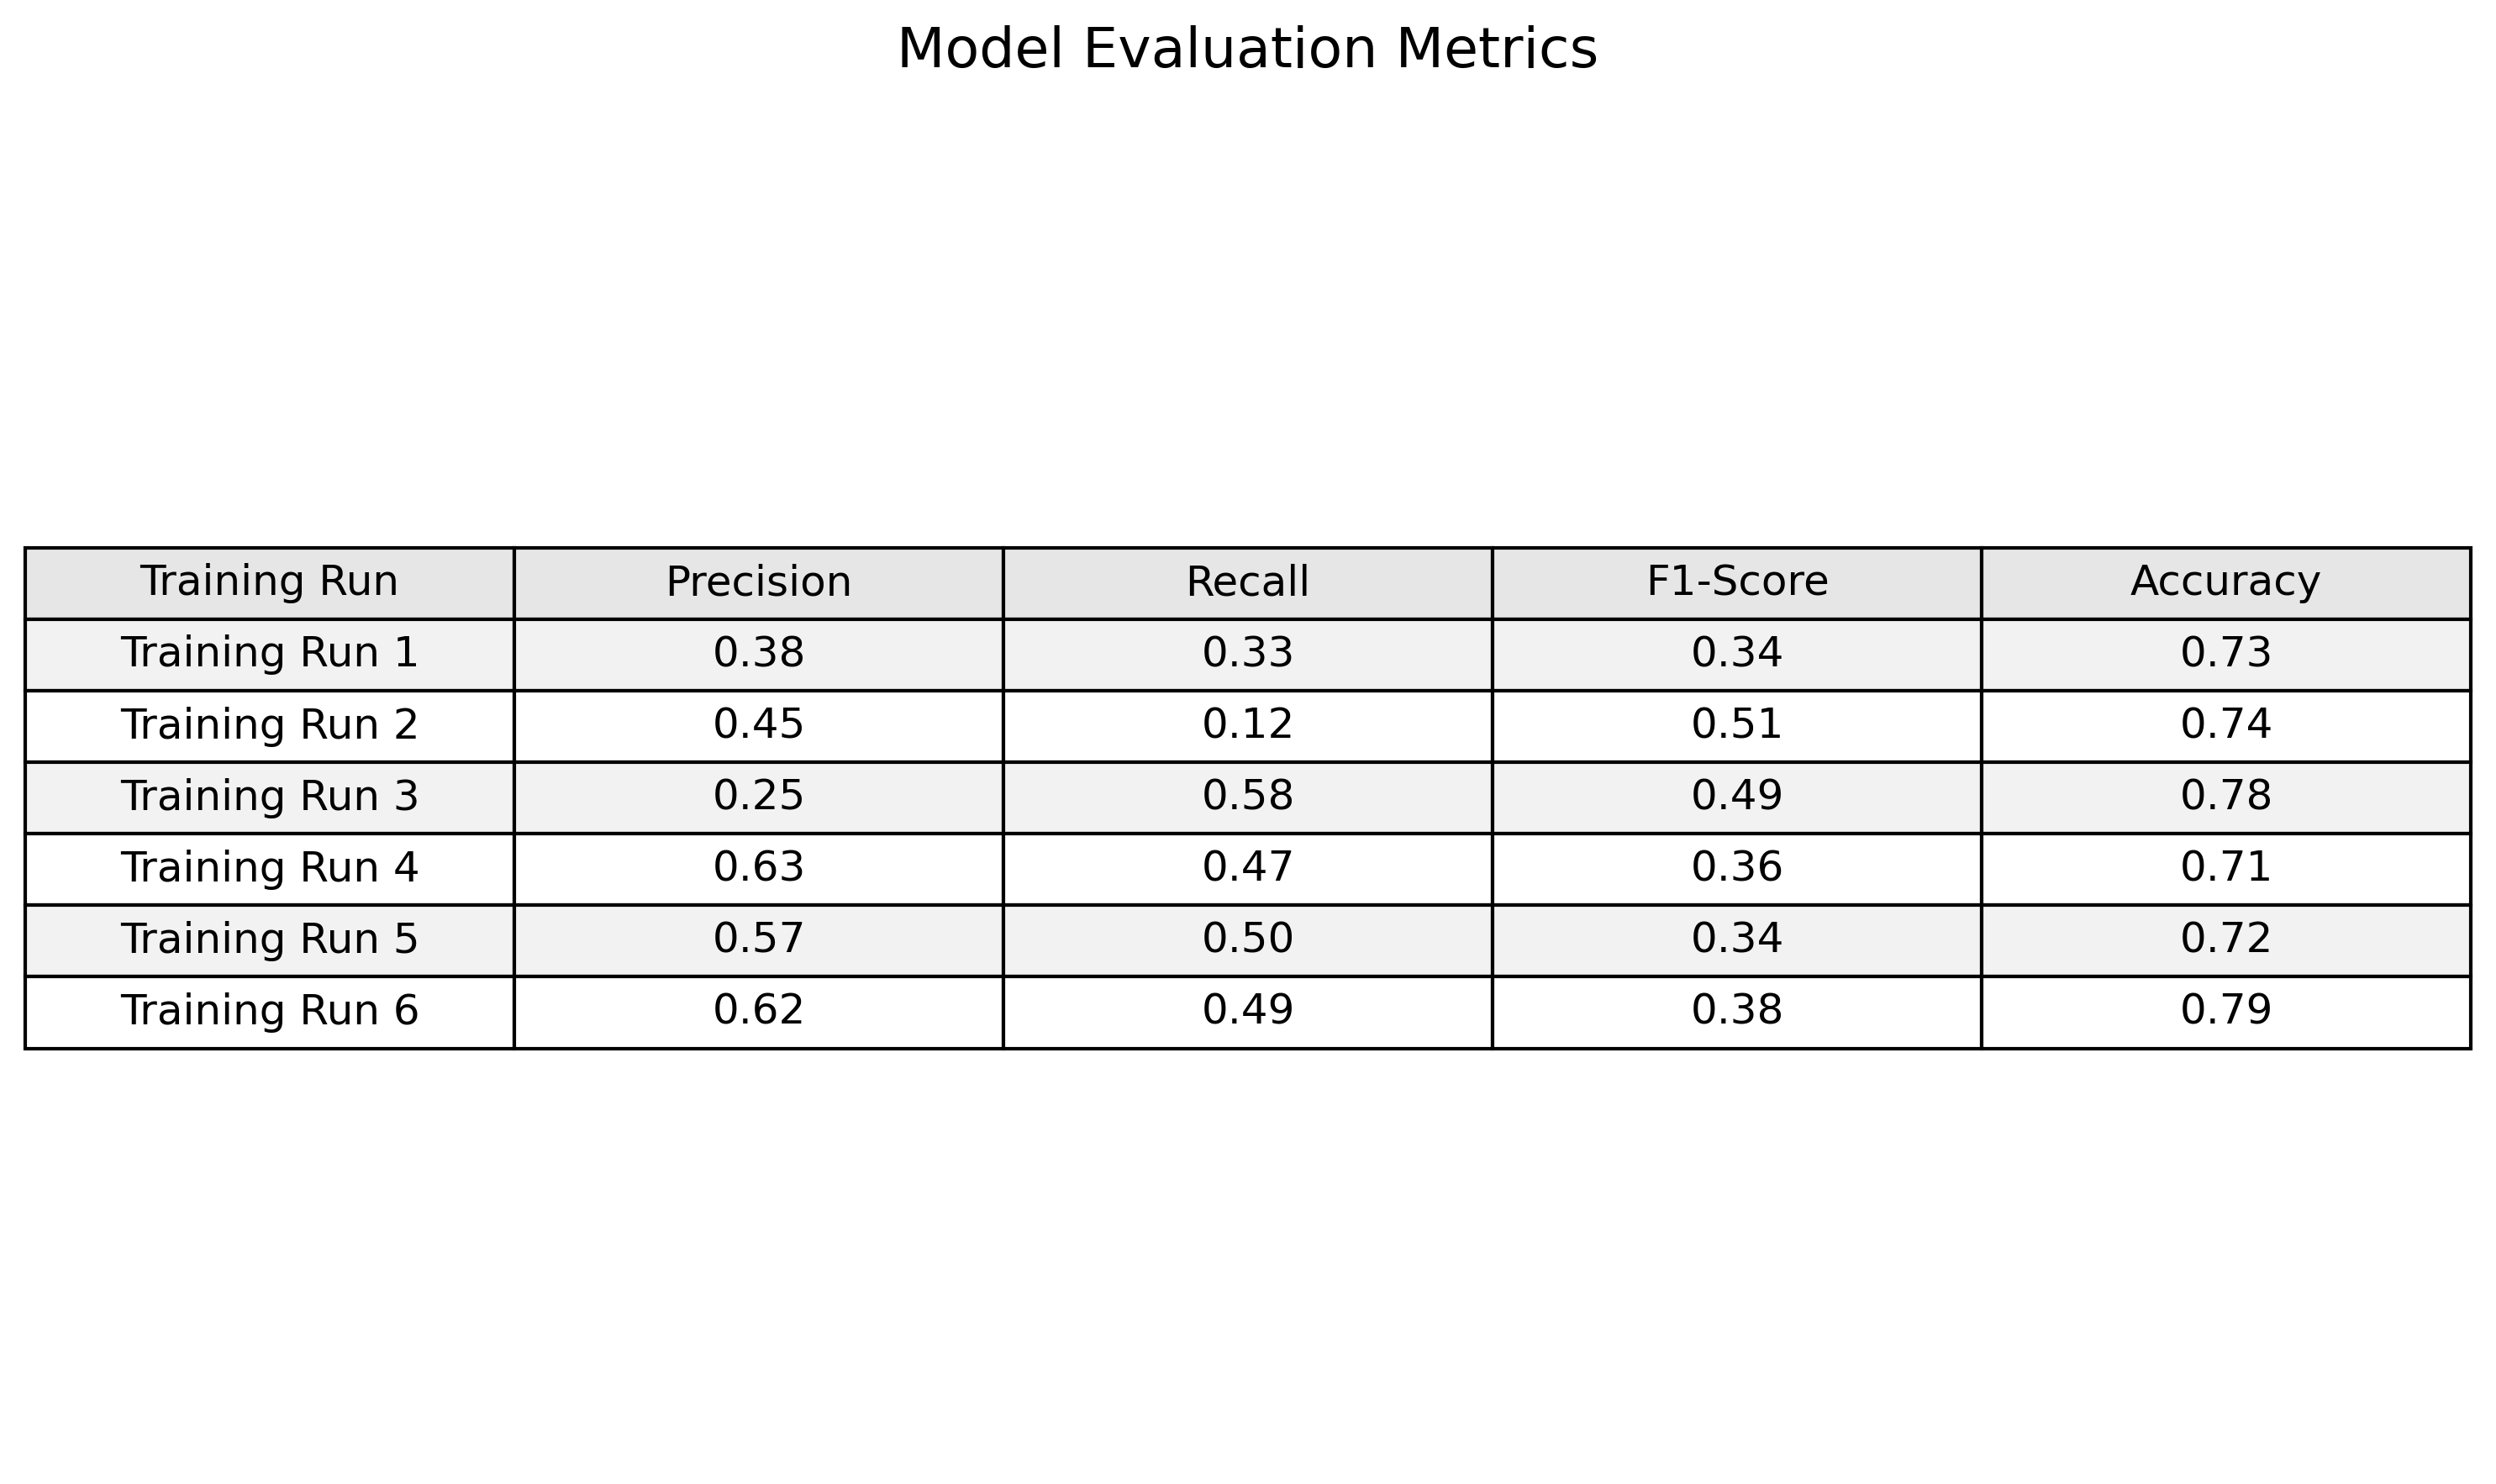

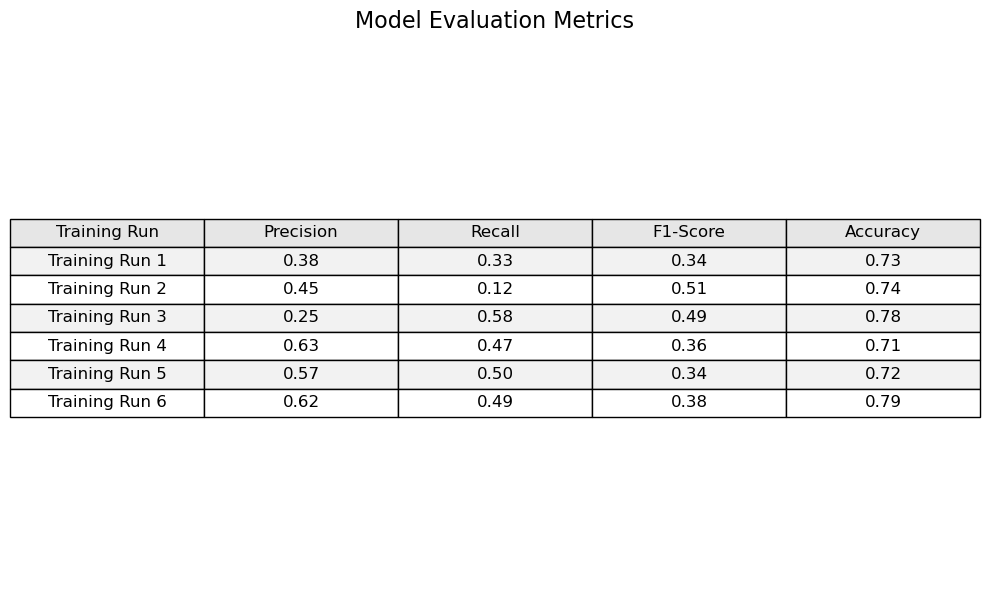

In [22]:
create_model_results_table(model_results)